Neural style transfer consists of applying the style of a reference image to a target
image while conserving the content of the target image

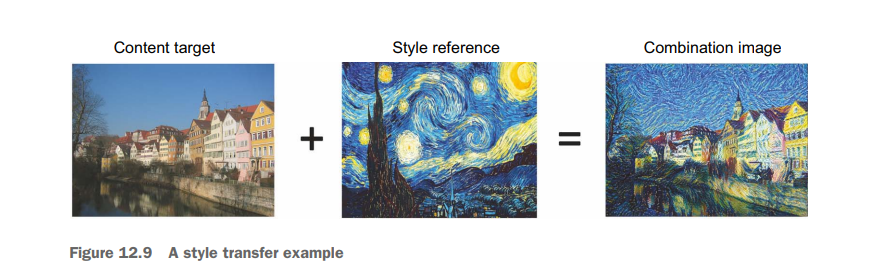

In this context, style essentially means textures, colors, and visual patterns in the
image, at various spatial scales, and the content is the higher-level macrostructure of
the image. For instance, blue-and-yellow circular brushstrokes are considered to be
the style and the buildings in
the Tübingen photograph are considered to be the content.

# Neural style transfer in Keras

Neural style transfer can be implemented using any pretrained convnet. Here, we’ll
use the VGG19 network used by Gatys et al. VGG19 is a simple variant of the VGG16
network, with three more convolutional layers.


 Here’s the general process:


 Set up a network that computes VGG19 layer activations for the style-reference
image, the base image, and the generated image at the same time.


 Use the layer activations computed over these three images to define the loss
function described earlier, which we’ll minimize in order to achieve style
transfer.

 Set up a gradient-descent process to minimize this loss function.


Let’s start by defining the paths to the style-reference image and the base image. To
make sure that the processed images are a similar size (widely different sizes make
style transfer more difficult), we’ll later resize them all to a shared height of 400 px.

In [1]:
from tensorflow import keras
base_image_path = keras.utils.get_file(
 "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg") # Path to the image we want to transform
style_reference_image_path = keras.utils.get_file(
 "starry_night.jpg",
 origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg") # Path to the style image

943128/943128 [==============================] - 0s 0us/step


In [2]:
original_width, original_height = keras.utils.load_img(base_image_path).size

# Dimensions of the generated picture
img_height = 400
img_width = round(original_width * img_height / original_height)

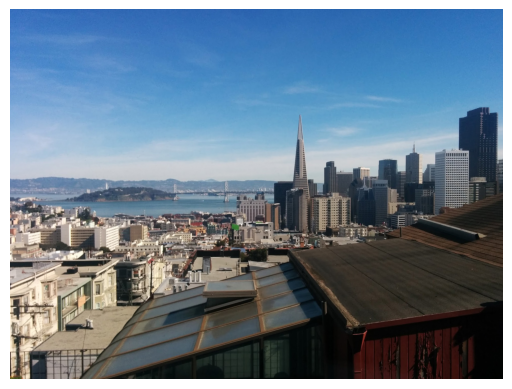

In [3]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

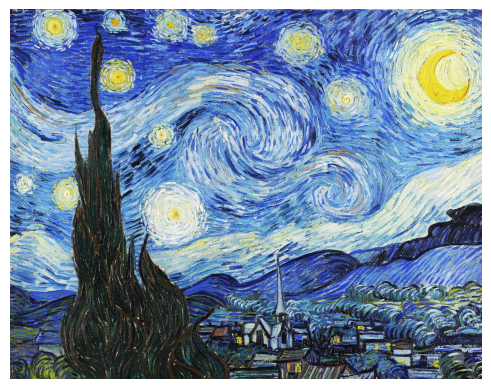

In [4]:
plt.axis("off")
plt.imshow(keras.utils.load_img(style_reference_image_path))

We also need some auxiliary functions for loading, preprocessing, and postprocessing
the images that go in and out of the VGG19 convnet.

In [5]:
import numpy as np

def preprocess_image(image_path): # Util function to open, resize, and format pictures into appropriate arrays
 img = keras.utils.load_img(
 image_path, target_size=(img_height, img_width))
 img = keras.utils.img_to_array(img)
 img = np.expand_dims(img, axis=0)
 img = keras.applications.vgg19.preprocess_input(img)
 return img

def deprocess_image(img): # Util function to convert a NumPy array into a valid image
 img = img.reshape((img_height, img_width, 3))

 # Zero-centering by removing the mean pixel value from ImageNet. This reverses a transformation done by vgg19.preprocess_input.
 img[:, :, 0] += 103.939
 img[:, :, 1] += 116.779
 img[:, :, 2] += 123.68
 img = img[:, :, ::-1] # Converts images from 'BGR' to 'RGB'. This is also part of the reversal of vgg19.preprocess_input.
 img = np.clip(img, 0, 255).astype("uint8")
 return img

[Why to convert BGR to RGB](https://chat.openai.com/share/352d9057-9f06-493e-aca2-6829888bdcba)

Let’s set up the VGG19 network. We’ll use the pretrained convnet to create a feature exactor model that returns the activations of intermediate layers—all layers in the model this time.

In [6]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict) # Model that returns the activation values for every target layer (as a dict)

80134624/80134624 [==============================] - 1s 0us/step


Let’s define the content loss, which will make sure the top layer of the VGG19 convnet
has a similar view of the base image and the combination image.

In [7]:
import tensorflow as tf

In [8]:
def content_loss(base_img, combination_img):
 return tf.reduce_sum(tf.square(combination_img - base_img))

Next is the style loss. It uses an auxiliary function to compute the Gram matrix of an
input matrix: a map of the correlations found in the original feature matrix.

In [9]:
def gram_matrix(x):
 x = tf.transpose(x, (2, 0, 1))
 features = tf.reshape(x, (tf.shape(x)[0], -1))
 gram = tf.matmul(features, tf.transpose(features))
 return gram

def style_loss(style_img, combination_img):
 S = gram_matrix(style_img)
 C = gram_matrix(combination_img)
 channels = 3
 size = img_height * img_width
 return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

To these two loss components, you add a third: the total variation loss, which operates
on the pixels of the generated combination image. It encourages spatial continuity in
the generated image, thus avoiding overly pixelated results. You can interpret it as a
regularization loss.

In [10]:
def total_variation_loss(x):
 a = tf.square(
 x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
 )
 b = tf.square(
 x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
 )
 return tf.reduce_sum(tf.pow(a + b, 1.25))

The loss that you minimize is a weighted average of these three losses. To compute the
content loss, you use only one upper layer—the block5_conv2 layer—whereas for the
style loss, you use a list of layers that spans both low-level and high-level layers. You add
the total variation loss at the end.

Depending on the style-reference image and content image you’re using, you’ll
likely want to tune the content_weight coefficient (the contribution of the content
loss to the total loss). A higher content_weight means the target content will be more
recognizable in the generated image.

[More expalnation about this](https://chat.openai.com/share/c9e94aa1-62e7-4547-b1ad-57a4863ce90e)

In [11]:
style_layer_names = [ # List of layers to use for the style loss
 "block1_conv1",
 "block2_conv1",
 "block3_conv1",
 "block4_conv1",
 "block5_conv1",
]
content_layer_name = "block5_conv2" # The layer to use for the content loss
total_variation_weight = 1e-6 # Contribution weight of the total variation loss
style_weight = 1e-6 # Contribution wieght of style loss
content_weight = 2.5e-8 # Contribution weight of the content loss

In [12]:
def compute_loss(combination_image, base_image, style_reference_image):
 input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
 features = feature_extractor(input_tensor)
 loss = tf.zeros(shape=())

 # Add the content loss
 layer_features = features[content_layer_name]
 base_image_features = layer_features[0, :, :, :]
 combination_features = layer_features[2, :, :, :]
 loss = loss + content_weight * content_loss(base_image_features, combination_features)

 # Add style loss
 for layer_name in style_layer_names:
    layer_features = features[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss_value = style_loss(
    style_reference_features, combination_features)
    loss += (style_weight / len(style_layer_names)) * style_loss_value
 loss += total_variation_weight * total_variation_loss(combination_image) # Add the total variation loss.
 return loss

[Above code explanation](https://chat.openai.com/share/57754ef0-6785-4260-8147-9183fee7c53f)

Finally, let’s set up the gradient-descent process. In the original Gatys et al. paper, optimization is performed using the L-BFGS algorithm, but that’s not available in TensorFlow, so we’ll just do mini-batch gradient descent with the SGD optimizer instead.

We’ll
leverage an optimizer feature you haven’t seen before: a learning-rate schedule. We’ll
use it to gradually decrease the learning rate from a very high value (100) to a much
smaller final value (about 20).

That way, we’ll make fast progress in the early stages of
training and then proceed more cautiously as we get closer to the loss minimum.

In [13]:
import tensorflow as tf
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
 with tf.GradientTape() as tape:
    loss = compute_loss(combination_image, base_image, style_reference_image)
 grads = tape.gradient(loss, combination_image)
 return loss, grads

optimizer = keras.optimizers.SGD(
 keras.optimizers.schedules.ExponentialDecay( # We’ll start with a learning rate of 100 and decrease it by 4% every 100 steps.
 initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
 )
)

Iteration 100: loss=8137.25
Iteration 200: loss=6651.40
Iteration 300: loss=6061.54
Iteration 400: loss=5741.23
Iteration 500: loss=5535.01
Iteration 600: loss=5389.13
Iteration 700: loss=5279.76
Iteration 800: loss=5194.11
Iteration 900: loss=5124.80
Iteration 1000: loss=5067.79
Iteration 1100: loss=5019.95
Iteration 1200: loss=4979.24
Iteration 1300: loss=4943.95
Iteration 1400: loss=4912.98
Iteration 1500: loss=4885.81
Iteration 1600: loss=4861.62
Iteration 1700: loss=4840.11
Iteration 1800: loss=4820.82
Iteration 1900: loss=4803.46
Iteration 2000: loss=4787.72
Iteration 2100: loss=4773.36
Iteration 2200: loss=4760.25
Iteration 2300: loss=4748.22
Iteration 2400: loss=4737.14
Iteration 2500: loss=4726.94
Iteration 2600: loss=4717.51
Iteration 2700: loss=4708.78
Iteration 2800: loss=4700.63
Iteration 2900: loss=4693.07
Iteration 3000: loss=4686.02
Iteration 3100: loss=4679.45
Iteration 3200: loss=4673.29
Iteration 3300: loss=4667.55
Iteration 3400: loss=4662.16
Iteration 3500: loss=46

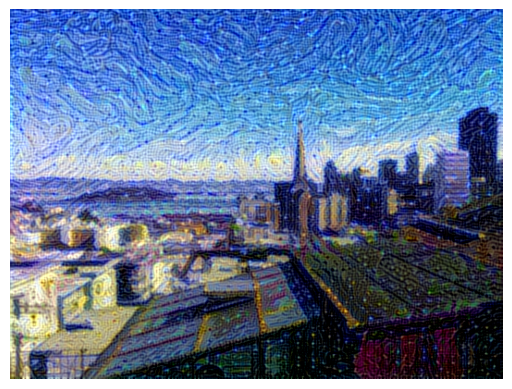

In [14]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path)) # Use a Variable to store the combination image since we’ll be updating it during training

iterations = 4000

for i in range(1, iterations + 1):
 loss, grads = compute_loss_and_grads(
 combination_image, base_image, style_reference_image
 )
 optimizer.apply_gradients([(grads, combination_image)]) # Update the combination image in a direction that reduces the style transfer loss.
 if i % 100 == 0:
    print(f"Iteration {i}: loss={loss:.2f}")
    img = deprocess_image(combination_image.numpy())
    fname = f"combination_image_at_iteration_{i}.png"
    keras.utils.save_img(fname, img)
    plt.axis("off")
    plt.imshow(keras.utils.load_img(fname))

Keep in mind that what this technique achieves is
merely a form of image retexturing, or texture transfer.

It works best with style-reference
images that are strongly textured and highly self-similar, and with content targets that
don’t require high levels of detail in order to be recognizable.

It typically can’t achieve
fairly abstract feats such as transferring the style of one portrait to another.


 The algorithm is closer to classical signal processing than to AI, so don’t expect it to work like
magic!

Additionally, note that this style-transfer algorithm is slow to run. But the transformation operated by the setup is simple enough that it can be learned by a small, fast feedforward convnet as well—as long as you have appropriate training data available.


Fast style transfer can thus be achieved by first spending a lot of compute cycles to
generate input-output training examples for a fixed style-reference image, using the
method outlined here, and then training a simple convnet to learn this style-specific
transformation. Once that’s done, stylizing a given image is instantaneous: it’s just a
forward pass of this small convnet.


Wrapping up


 Style transfer consists of creating a new image that preserves the contents of a
target image while also capturing the style of a reference image.


 Content can be captured by the high-level activations of a convnet.


 Style can be captured by the internal correlations of the activations of different
layers of a convnet.


 Hence, deep learning allows style transfer to be formulated as an optimization
process using a loss defined with a pretrained convnet.


 Starting from this basic idea, many variants and refinements are possible.